In [1]:
from utils import *
from build_model import *

'''
Dataset: Particles
Dataset: Particles_Classes
Dataset: Particles_Names

array([b'MET_class_1', b'Four_Ele_class_2', b'Four_Mu_class_3',
       b'Ten_Jet_class_4'], dtype='|S16')
       
array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')

shape = (n, 19, 4)
'''

files = ['background_for_training.h5',
         'Ato4l_lepFilter_13TeV_filtered.h5',
         'hChToTauNu_13TeV_PU20_filtered.h5',
         'hToTauTau_13TeV_PU20_filtered.h5',
         'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

data = []
for i in range(len(files)):
    with h5py.File(files[i], 'r') as hdf:
        if i == 0:
            data.append(hdf['Particles'][:200000])
        else:
            data.append(hdf['Particles'][:])
    print(data[i].shape)

data[1][2]

(200000, 19, 4)
(55969, 19, 4)
(760272, 19, 4)
(691283, 19, 4)
(340544, 19, 4)


array([[ 6.76132965,  0.        ,  1.15189862,  1.        ],
       [28.02878571,  0.0848856 , -1.33467388,  2.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 7.86102533,  0.0485602 ,  1.2370621 ,  3.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [41.65947342,  0.95587289, -2.99767089,  4.        ],
       [29.83676529,  0.91927922,  0.05157597,  4.        ],
       [28.80836487,  0.09456544, -1.33484852,  4.        ],
       [24.68841934, -1.10409391, -2.82231712,  4.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [ ]:
plot_data(data, 'MET')
plot_data(data, 'Ele')
plot_data(data, 'Mu')
plot_data(data, 'Jet')

## preprocess data

In [2]:
# remove last feature (particle class), which is implicitly assumed in second index ordering
for i in range(len(data)):
    data[i] = np.reshape(data[i][:,:,:3], (data[i].shape[0], -1))

# training data: bkg only
X = data[0]

train_ratio = 0.6
val_ratio = 0.01
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
del X_train_val

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

for i in range(1, 5):
    data[i] = scaler.transform(data[i])

X_train shape: (120000, 57)
X_val   shape: (2000, 57)
X_test  shape: (78000, 57)


## baseline ae model

In [ ]:
model_ae = build_autoencoder(input_dim=57)
model_ae.summary()

In [ ]:
history = model_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=20, batch_size=128)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'train')
axes.plot(history.history['val_loss'], label = 'val')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

score_x_test = compute_mse_for_ae(model_ae, X_test)
score_sig = []
for i in range(4):
    score_sig.append(compute_mse_for_ae(model_ae, data[i+1]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_x_test, bins=50, alpha=0.5, label='Bkg', density=True)

for i, score_vals in enumerate(score_sig):
    plt.hist(score_vals, bins=50, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('MSE')
#plt.xlim((0,10000))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_x_test, score_sig[i]])
    labels = np.concatenate([np.zeros_like(score_x_test), np.ones_like(score_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

## flow model

Epoch 1/40, Loss: -4.4229
Epoch 2/40, Loss: -8.6917
Epoch 3/40, Loss: -9.8025
Epoch 4/40, Loss: -10.6016
Epoch 5/40, Loss: -11.2695
Epoch 6/40, Loss: -11.5319
Epoch 7/40, Loss: -11.8458
Epoch 8/40, Loss: -12.2816
Epoch 9/40, Loss: -11.9063
Epoch 10/40, Loss: -12.2509
Epoch 11/40, Loss: -12.6421
Epoch 12/40, Loss: -12.4423
Epoch 13/40, Loss: -12.6855
Epoch 14/40, Loss: -12.8989
Epoch 15/40, Loss: -12.5558
Epoch 16/40, Loss: -12.6669
Epoch 17/40, Loss: -12.8434
Epoch 18/40, Loss: -12.9743
Epoch 19/40, Loss: -12.7828
Epoch 20/40, Loss: -13.3132
Epoch 21/40, Loss: -12.8771
Epoch 22/40, Loss: -11.7792
Epoch 23/40, Loss: -13.0320
Epoch 24/40, Loss: -13.3628
Epoch 25/40, Loss: -13.4634
Epoch 26/40, Loss: -12.5771
Epoch 27/40, Loss: -13.2356
Epoch 28/40, Loss: -11.8537
Epoch 29/40, Loss: -12.4034
Epoch 30/40, Loss: -12.7130
Epoch 31/40, Loss: -12.2679
Epoch 32/40, Loss: -13.1197
Epoch 33/40, Loss: -13.2150
Epoch 34/40, Loss: -13.1247
Epoch 35/40, Loss: -13.1314
Epoch 36/40, Loss: -13.0876
Epoc

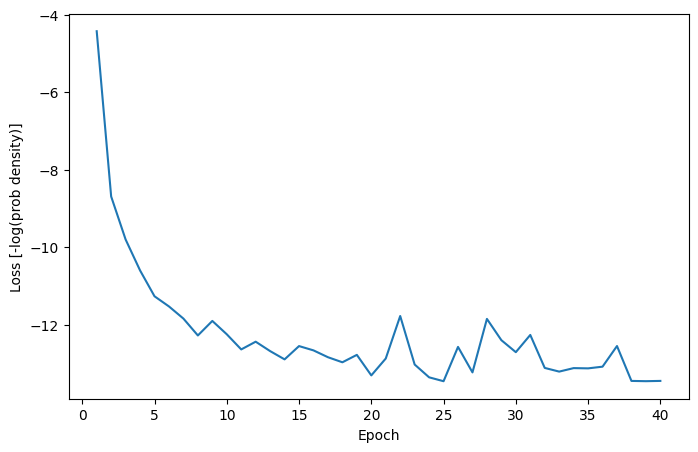

In [3]:
epochs = 40
batch_size = 128

model_nf = NormalizingFlowModel(num_flows=3)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(batch_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.006)

epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            loss = nll_loss(model_nf, x_batch)
        grads = tape.gradient(loss, model_nf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_nf.trainable_variables))
        epoch_loss += loss.numpy()
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss [-log(prob density)]")
plt.show()

nll_x_test = compute_nll_for_nf(model_nf, X_test)

nll_sig = []
for i in range(4):
    nll_sig.append(compute_nll_for_nf(model_nf, data[i+1]))

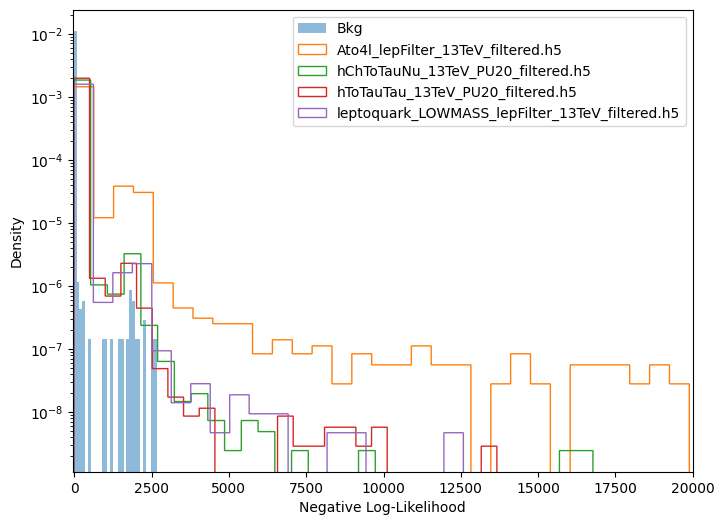

In [11]:
plt.figure(figsize=(8,6))
plt.hist(nll_x_test, bins=30, alpha=0.5, label='Bkg', density=True)

for i, nll_vals in enumerate(nll_sig):
    plt.hist(nll_vals, bins=100000, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('Negative Log-Likelihood')
plt.ylabel('Density')
plt.xlim((-50,20000))
plt.yscale('log')
plt.legend()
plt.show()

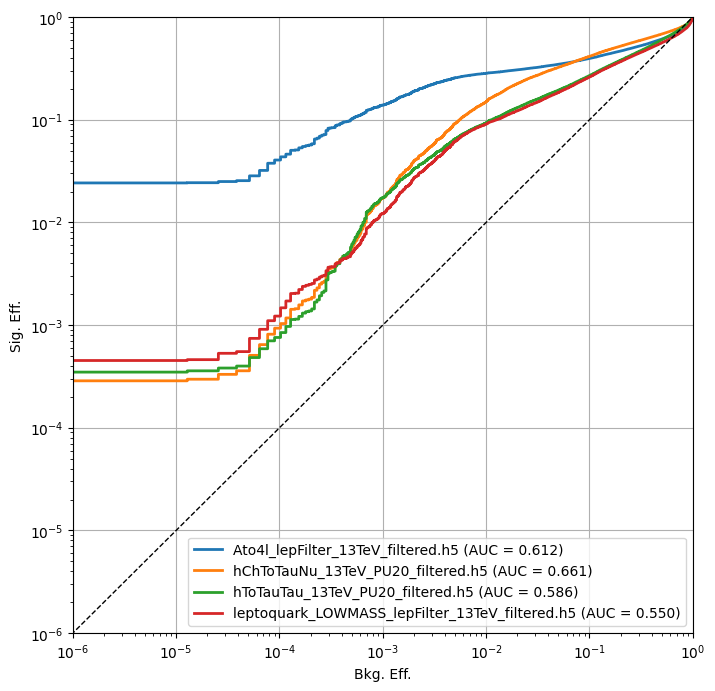

In [12]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([nll_x_test, nll_sig[i]])
    labels = np.concatenate([np.zeros_like(nll_x_test), np.ones_like(nll_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

## hls